In [1]:
# install support packages
!pip install jenkspy
!pip install mne

In [2]:
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering

import spacy
from spacy.matcher import PhraseMatcher

import jenkspy

import matplotlib.pyplot as plt

import seaborn as sns
import mne

import textwrap

In [3]:
# ensure reproducible results
rand_state = 1234

In [4]:
# path configuration
PROCESSED_DATA_URL = "https://github.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/COVID-Fake-News-Analysis/raw/main/data/processed/COVIDFakeNewsProcessedData.zip";

# read basic data
# we will used "binary_target" as the classification label
# and "tokens_text_processed_joined" mostly as a source of training data

processed_data = pd.read_csv(PROCESSED_DATA_URL, index_col=None);

In [5]:
# configuration metadata
# empirically fine tuned for the best results
# changing this configuration may cause some of the functionality
# related to cluster information display to malfunction
# modify at your own risk
BIAS_CLIP_THRESHOLD_VALUE = 0.3
DISTANCE_THRESHOLD = 0.7

In [6]:
# define the target data column name used for analytics

target_data_column_name = "tokens_text_processed_joined";

In [7]:
# create convenience data vectors
authentic_news = processed_data[processed_data["binary_target"] == 0];
generic_fake_news = processed_data[processed_data["binary_target"] == 1];

partially_fake_news = processed_data[processed_data["multi_target"] == 1];
fake_news = processed_data[processed_data["multi_target"] == 2];

In [8]:
# creates a count vectorization representation for data
# storing the 
def get_count_vectorization(data) :

  count_vectorizer = CountVectorizer();
  vectorized_data = count_vectorizer.fit_transform(data);
  features_names = count_vectorizer.get_feature_names();
  
  vectorized_data = vectorized_data.toarray();
  features_names = np.array(features_names); 

  return vectorized_data, features_names; 

# creates a normalized document - count vectorization data for a token 
# this is a simplified TFIDF approach where a term occurence is
# divided to the number of documents
def get_doc_normalized_vectorization(data, n_documents) :
  vectorized_data, feature_names = get_count_vectorization(data);

  all_occurences = np.sum(vectorized_data);
  normalized_occurences = vectorized_data / all_occurences;

  return normalized_occurences, feature_names 

# gets normalized mapping
# per feature names
def get_normalized_mapping(normalized_occurences, feature_names) :

  mapping = {};

  for i in range(0, normalized_occurences.shape[0]) :
    mapping[feature_names[i]] = normalized_occurences[i];

  return mapping;

# gets terms comparison
def get_comparison_data(
    source_mappings,
    target_mappings,
    feature_names_column_name = "feature_names",
    source_output_column_name = "source_occurences_value",
    target_output_column_name = "target_occurences_value"
) :
  joined_features_names = np.array(list(set(list(set(source_mappings.keys())) + list(set(target_mappings.keys())))));

  feature_names = [];
  source_occurences_value = [];
  target_occurences_value = [];
  
  for feature_name in joined_features_names :
    source_occurence_value = 0

    if feature_name in source_mappings :
      source_occurence_value = source_mappings[feature_name];

    target_occurence_value = 0

    if feature_name in target_mappings :
      target_occurence_value = target_mappings[feature_name];

    feature_names = np.append(feature_names, feature_name);
    source_occurences_value = np.append(source_occurences_value, source_occurence_value);
    target_occurences_value = np.append(target_occurences_value, target_occurence_value);

  data = pd.DataFrame.from_dict({
      feature_names_column_name: feature_names,
      source_output_column_name: source_occurences_value,
      target_output_column_name: target_occurences_value
  });

  return data;

In [9]:
# create count vectorization data
authentic_news_vectorization_data, authentic_news_feature_names = get_count_vectorization(authentic_news); 
generic_fake_news_vectorization_data, generic_fake_news_feature_names = get_count_vectorization(generic_fake_news); 

# create data for document terms comparation
all_authentic_news = " ".join(authentic_news[target_data_column_name]);
all_fake_news = " ".join(generic_fake_news[target_data_column_name]);

all_authentic_news_vectorized_data, all_authentic_news_feature_names = get_doc_normalized_vectorization([all_authentic_news], authentic_news.shape[0]);
all_generic_fake_news_vectorized_data, all_generic_fake_news_feature_names = get_doc_normalized_vectorization([all_fake_news], fake_news.shape[0]);

all_authentic_news_mapping = get_normalized_mapping(np.squeeze(all_authentic_news_vectorized_data), all_authentic_news_feature_names);
all_fake_news_mapping = get_normalized_mapping(np.squeeze(all_generic_fake_news_vectorized_data), all_generic_fake_news_feature_names);

In [10]:
# get the comparison data
comparison_data = get_comparison_data(all_authentic_news_mapping, all_fake_news_mapping,"token" ,"authentic_news_occurences" , "fake_news_occurences");

In [11]:
# remove data that have a low bias
# compared to number of occurence in 
# source and target data 
def clip_low_bias_data(
    base_data,
    source_output_column_name = "source_occurences_value",
    target_output_column_name = "target_occurences_value",
    clip_value = 0.02   
):

  data_clipped = base_data.copy();

  data_clipped["should_be_clipped"] = \
    ((abs(data_clipped[source_output_column_name] - data_clipped[target_output_column_name])) /
     (data_clipped[source_output_column_name] + data_clipped[target_output_column_name])) < clip_value;

  data_clipped = data_clipped[~data_clipped["should_be_clipped"]];
  data_clipped = data_clipped.drop(["should_be_clipped"], axis = 1);

  return data_clipped;

# gets tread break indexes
def get_trend_break_indexes (
    base_data, 
    terms_column_name, 
    authentic_news_bias_column_name, 
    fake_news_bias_column_name, 
    authentic_news_flag, 
    count_breaking_points = 1
  ) :
  
  # determine the target space 
  # for authentic news this space is associated with terms that occur more frequent
  target_space = []
  if (authentic_news_flag) :
    target_space = base_data[(base_data[authentic_news_bias_column_name] - base_data[fake_news_bias_column_name]) > 0];
  else :  
    target_space = base_data[(base_data[authentic_news_bias_column_name] - base_data[fake_news_bias_column_name]) < 0];
  
  # determine terms that have the strongest bias values
  bias_values = abs(target_space[authentic_news_bias_column_name] - target_space[fake_news_bias_column_name]);

  arg_sorted = np.flip(np.argsort(bias_values.values));
  sorted_bias_values = bias_values.iloc[arg_sorted];

  # determine break values
  break_values = np.array(jenkspy.jenks_breaks(sorted_bias_values, nb_class = count_breaking_points + 1));

  # determine trend breaking indexes
  break_indexes = [];

  for i in range(0, break_values.shape[0]) :
    index = sorted_bias_values[sorted_bias_values.values > break_values[i]].shape[0]
    break_indexes = np.append(break_indexes, index)

  trend_break_indexes = np.flip(np.array(break_indexes, dtype="int"))

  return sorted_bias_values, trend_break_indexes

# gets positional token data
def get_positional_token_data (
    base_data, 
    index_data, 
    lower_bound, 
    upper_bound,
    feature_names_column_name = "feature_names",
    source_output_column_name = "source_occurences_value",
    target_output_column_name = "target_occurences_value"  
  ) :
  index_slice = index_data.iloc[lower_bound: upper_bound];
  data_slice = base_data.loc[index_slice.index];

  result_dataframe = pd.DataFrame();
  result_dataframe["tokens"] = data_slice[feature_names_column_name];
  result_dataframe[source_output_column_name] = data_slice[source_output_column_name];
  result_dataframe[target_output_column_name] = data_slice[target_output_column_name];
  result_dataframe["bias"] = abs(data_slice[source_output_column_name] - data_slice[target_output_column_name]);

  return result_dataframe;

In [12]:
# clip low bias tokens
# related to fake and news stories

clipped_comparison_data = clip_low_bias_data(
    comparison_data,
    "authentic_news_occurences",
    "fake_news_occurences",
    BIAS_CLIP_THRESHOLD_VALUE
)

# determine tokens associated with authentic news
# along with their bias
# we will use only one breaking trend point (two regions)
authentic_news_sorted_bias_values, authentic_news_trend_break_indexes = get_trend_break_indexes (
  clipped_comparison_data,
  "token",
  "authentic_news_occurences",
  "fake_news_occurences",
  True
);

# determine tokens associated with fake news
# along with their bias
# we will use only one breaking trend point (two regions)
fake_news_sorted_bias_values, fake_news_trend_break_indexes = get_trend_break_indexes (
  clipped_comparison_data,
  "token",
  "authentic_news_occurences",
  "fake_news_occurences",
  False  
);

# get the information for authentic news relevant tokens
authentic_news_token_data = get_positional_token_data(
  clipped_comparison_data, 
  authentic_news_sorted_bias_values, 
  authentic_news_trend_break_indexes[0], 
  authentic_news_trend_break_indexes[1],
  "token",
  "authentic_news_occurences",
  "fake_news_occurences"  
);

# get the information for fake news relevant tokens
fake_news_token_data = get_positional_token_data(
  clipped_comparison_data, 
  fake_news_sorted_bias_values, 
  fake_news_trend_break_indexes[0], 
  fake_news_trend_break_indexes[1],
  "token",
  "authentic_news_occurences",
  "fake_news_occurences"  
);

In [13]:
# display basic authentic news token information
authentic_news_tokens = authentic_news_token_data["tokens"].values;

print(
  "There are {} relevant tokens for authentic stories. They are as follows: \n {}.".format(
      authentic_news_tokens.shape[0],
      authentic_news_tokens
  )
);

There are 8 relevant tokens for authentic stories. They are as follows: 
 ['health' 'ncov' 'case' 'travel' 'countri' 'confirm' 'novel' 'citi'].


In [14]:
# display basic fake news token information
fake_news_tokens = fake_news_token_data["tokens"].values;

print(
  "There are {} relevant tokens for fake stories. They are as follows: \n {}.".format(
      fake_news_tokens.shape[0],
      fake_news_tokens
  )
);

There are 74 relevant tokens for fake stories. They are as follows: 
 ['covid' 'vaccin' 'pandem' 'cell' 'studi' 'look' 'cancer' 'bat' 'american'
 'god' 'drug' 'differ' 'think' 'fact' 'natur' 'medicin' 'lab' 'cure'
 'antibodi' 'immun' 'want' 'articl' 'clear' 'lockdown' 'trump' 'protein'
 'life' 'read' 'ace' 'ultrasound' 'minut' 'hius' 'actual' 'power' 'lung'
 'white' 'scienc' 'biolog' 'forward' 'video' 'futur' 'interest' 'vitamin'
 'light' 'hous' 'program' 'trial' 'publish' 'weapon' 'stori' 'christian'
 'photo' 'tell' 'analysi' 'cat' 'reopen' 'therapi' 'asian' 'segment'
 'gene' 'express' 'attack' 'love' 'heart' 'big' 'play' 'cost' 'bill'
 'plasma' 'project' 'cannabi' 'aid' 'devic' 'save'].


In [15]:
# plots category bias (authentic or fake) for tokens
def plot_category_bias(
    data, # the data used for plotting
    labels_column_name, # the column name for labels
    principal_category_column_name, # the column name for principal category
    secondary_category_column_name, # the column name for secondary category
    bias_column_name, # the column name for bias
    principal_category_name, # the principal category name
    secondary_category_name, # the secondary category name
    bias_name, # the name for bias
    principal_category_color, # the principal category name
    secondary_category_color, # the secondary category color
    figsize, # the figure size
    title, # the plot title
    subtitle, # the plot subtitle
) :
  fig, ax = plt.subplots(figsize = figsize);

  ax.bar(data[labels_column_name], data[principal_category_column_name], color = principal_category_color, alpha = 0.5);
  ax.bar(data[labels_column_name], data[secondary_category_column_name], color = secondary_category_color, alpha = 0.5);
  ax.bar(data[labels_column_name], data[bias_column_name], color = principal_category_color, width =0.5);

  ax.patch.set_visible(False);
  ax.set_facecolor('white');

  fig.patch.set_visible(False);
  fig.gca().set_frame_on(False);  

  plt.xticks(rotation = 90, fontsize = 20);
  plt.yticks([]);

  plt.title(title + "\n\n", fontsize = 20);
  plt.suptitle(subtitle, fontsize = 15)

  plt.show();

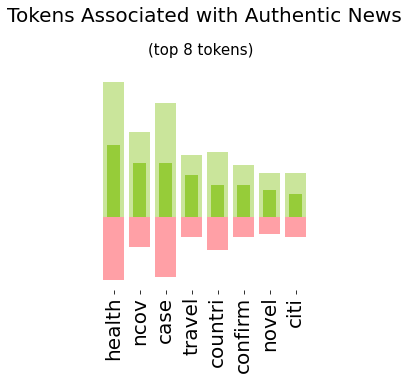

In [16]:
# plot the data for authentic news tokens
# we limit to at mostly 10 terms

plot_data = authentic_news_token_data[0:10].copy();
plot_data["fake_news_occurences"] = -plot_data["fake_news_occurences"];

plot_category_bias (
    plot_data,
    "tokens",
    "authentic_news_occurences",
    "fake_news_occurences",
    "bias",
    "authentic News",
    "Fake News",
    "Bias",
    "#96CC39",
    "#FF424E",
    (4,4),
    "Tokens Associated with Authentic News",
    "(top {} tokens)".format(plot_data.shape[0])  
);

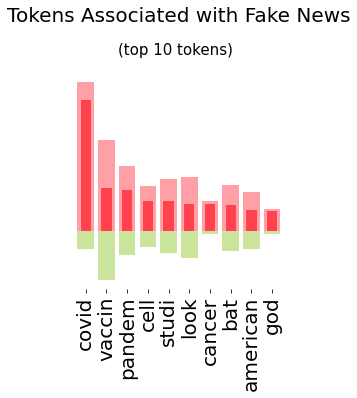

In [17]:
# plot the data for fake news tokens
# we limit to at mostly 10 terms

plot_data = fake_news_token_data[0:10].copy();
plot_data["authentic_news_occurences"] = -plot_data["authentic_news_occurences"];

plot_category_bias (
    plot_data,
    "tokens",
    "fake_news_occurences",
    "authentic_news_occurences",
    "bias",
    "Fake News",
    "authentic News",
    "Bias",
    "#FF424E",
    "#96CC39",
    (4, 4),
    "Tokens Associated with Fake News",
    "(top {} tokens)".format(plot_data.shape[0])
);

In [18]:
# get tokens matches count for each item in the corpus
# i.e. how many matches have been found per each item

def get_tokens_corpus_matches_count (corpus, tokens) :
  vectorization_data, feature_names = get_count_vectorization(corpus);
  vectorization_data_for_tokens = vectorization_data[:, np.isin(feature_names, tokens)];
  vectorization_data_for_tokens_sum = np.sum(vectorization_data_for_tokens, axis = 1);
  
  coverage = vectorization_data_for_tokens_sum[vectorization_data_for_tokens_sum > 0].shape[0]/vectorization_data_for_tokens_sum.shape[0];
  return coverage;

In [19]:
# prints the authentic news coverage
authentic_news_corpus_coverage = get_tokens_corpus_matches_count(
    authentic_news["tokens_text_processed_joined"], 
    authentic_news_token_data["tokens"]
  );
print("Authentic news coverage by authentic news tokens: {:.2f}%".format(100*authentic_news_corpus_coverage));

# prints the fake news coverage
fake_news_corpus_coverage = get_tokens_corpus_matches_count(
    fake_news["tokens_text_processed_joined"], 
    fake_news_token_data["tokens"]
  );
print("Fake news coverage by fake news tokens: {:.2f}%".format(100*fake_news_corpus_coverage));

# prints the entire corpus coverage
corpus_coverage = get_tokens_corpus_matches_count(
    processed_data["tokens_text_processed_joined"], 
    np.append(authentic_news_token_data["tokens"], fake_news_token_data["tokens"])
  );
print("Corpus coverage by authentic&fake news tokens: {:.2f}%".format(100*corpus_coverage));

Authentic news coverage by authentic news tokens: 95.27%
Fake news coverage by fake news tokens: 95.38%
Corpus coverage by authentic&fake news tokens: 99.13%


In [20]:
# obtains the co-occurence matrix for tokens within a corpus
# the co-occurence is basically measuring in how many corpus 
# items the terms are appearing together
# this matrix must be diagonally zero as well
def get_co_occurence_matrix(
    corpus, # the corpus used for building the co-occurence matrix
    tokens  # the target tokens
) :  

  vectorization_data, feature_names = get_count_vectorization(corpus);
  matching_data = vectorization_data[:, np.isin(feature_names, tokens)];
#  matching_data[matching_data[:,] > 0] = 1;
  token_feature_names = feature_names[np.isin(feature_names, tokens)] 

  transp_matching_data = np.transpose(matching_data);

  transp_reordered_matching_data = transp_matching_data.copy();

  for token in tokens:
    index_token = np.where(tokens == token)[0];
    index_feature = np.where(token_feature_names == token)[0];
    transp_reordered_matching_data[index_token] = transp_matching_data[index_feature];

  reordered_matching_data = np.transpose(transp_reordered_matching_data);
  raw_reordered_matching_data = reordered_matching_data.copy();
  reordered_matching_data[reordered_matching_data[:,] > 0] = 1;

  co_occurence_matrix = np.transpose(reordered_matching_data).dot(reordered_matching_data);
  np.fill_diagonal(co_occurence_matrix, 0);

  return raw_reordered_matching_data, reordered_matching_data, co_occurence_matrix;

In [21]:
# determine the authentic news co-occurence matrix
authentic_news_tokens = authentic_news_token_data["tokens"].values;
authentic_news_corpus = authentic_news["tokens_text_processed_joined"];
raw_authentic_news_matching_data, authentic_news_matching_data, authentic_news_co_occurence_matrix = get_co_occurence_matrix(authentic_news_corpus, authentic_news_tokens);

# determine the fake news co-occurence matrix
fake_news_tokens = fake_news_token_data["tokens"].values;
fake_news_corpus = generic_fake_news["tokens_text_processed_joined"];
raw_fake_news_matching_data, fake_news_matching_data, fake_news_co_occurence_matrix = get_co_occurence_matrix(fake_news_corpus, fake_news_tokens);

In [22]:
# creates clusters of tokens based on their co-occurence
# either use number of clusters or distance_threshold
def clusterize_tokens(
    co_occurence_matrix, # the co-occurence matrix
    number_of_clusters = None, # the number of generated clusters
    distance_threshold = None # the distance threshold for clusterization
):

  # calculate distance matrix using co-occurence matrix
  # scaled down to unit value
  dist_matrix = 1 - MinMaxScaler().fit_transform(co_occurence_matrix);

  # create an agglomerative clustering model
  # and determine clusters of high co-occurence values
  model = AgglomerativeClustering(
      affinity = 'precomputed', 
      n_clusters = number_of_clusters,
      distance_threshold = distance_threshold, 
      linkage='complete');
  
  model.fit(dist_matrix);

  return model.labels_;    

In [23]:
# slices the matching data so it will contain
# only the data for a target cluster
def get_cluster_matching_data(
    matching_data,
    cluster_data,
    cluster_label 
):

  cluster_indexes = np.where(cluster_data == cluster_label);

  cluster_matching_data = np.squeeze(matching_data[:, cluster_indexes]);
  if (cluster_matching_data.ndim == 1) :
    cluster_matching_data = np.transpose(np.array([cluster_matching_data]));

  return cluster_matching_data;

# gets the news which are covered simultaneously
# by tokens from two clusters
def get_clusters_news_intersection(
    matching_data,
    cluster_data,
    cluster_label_1,
    cluster_label_2
):
  cluster_1_matching_data = get_cluster_matching_data(
    matching_data,
    cluster_data,
    cluster_label_1      
  );

  cluster_2_matching_data = get_cluster_matching_data(
    matching_data,
    cluster_data,
    cluster_label_2      
  );

  cluster_1_tokens_count = np.sum(cluster_1_matching_data, axis = 1);
  cluster_2_tokens_count = np.sum(cluster_2_matching_data, axis = 1);

  intersection_marker = cluster_1_tokens_count * cluster_2_tokens_count;
  intersection_marker[intersection_marker > 0] = 1;

  intersection_indices = np.where(intersection_marker > 0)[0];

  return intersection_indices;

# gets the news which are covered at least
# by a token from two clusters
def get_clusters_news_union(
    matching_data,
    cluster_data,
    cluster_label_1,
    cluster_label_2
):
  cluster_1_matching_data = get_cluster_matching_data(
    matching_data,
    cluster_data,
    cluster_label_1      
  );

  cluster_2_matching_data = get_cluster_matching_data(
    matching_data,
    cluster_data,
    cluster_label_2      
  );

  cluster_1_tokens_count = np.sum(cluster_1_matching_data, axis = 1);
  cluster_2_tokens_count = np.sum(cluster_2_matching_data, axis = 1);

  union_marker = cluster_1_tokens_count + cluster_2_tokens_count;
  union_marker[union_marker > 0] = 1;

  union_indices = np.where(union_marker > 0)[0];

  return union_indices;  

# gets the two clusters IOU
# (i.e. count of common news divided by count of union of news associated to 
# both clusters)
def get_clusters_IOU(   
    matching_data,
    cluster_data,
    cluster_label_1,
    cluster_label_2
):

  intersection_indices = get_clusters_news_intersection (
      matching_data,
      cluster_data,
      cluster_label_1,
      cluster_label_2    
  );

  union_indices = get_clusters_news_union (
      matching_data,
      cluster_data,
      cluster_label_1,
      cluster_label_2    
  );

  iou_value = intersection_indices.shape[0] / union_indices.shape[0];
  
  return iou_value;

# gets the similarity matrix for a set of clusters
# the higher the IOU value for two cluster, the more related those clusters are
def get_clusters_similarity_matrix (
    matching_data,
    cluster_data
):
  cluster_labels = np.sort(np.unique(cluster_data));
  similarity_matrix = np.full((cluster_labels.shape[0], cluster_labels.shape[0]), 0.0);  

  for label_x in cluster_labels :
    for label_y in cluster_labels:
      similarity_matrix[label_x, label_y] = get_clusters_IOU (
        matching_data,
        cluster_data,
        label_x,
        label_y
      );

  np.fill_diagonal(similarity_matrix, 0);

  return similarity_matrix;

In [24]:
# clusterizes the data
# ensuring an optimal number of clusters in relation with
# a minimal IOU value
def optimal_clustering(
    matching_data,
    co_occurence_matrix,
    min_IOU,
    min_threshold = 0.25,
    decrement_step = 0.1
):

  labels_clusters = [];
  for threshold in range(100, round(100 * min_threshold), round(-decrement_step*100)):
    labels_clusters = clusterize_tokens(
        co_occurence_matrix,
        distance_threshold = threshold  / 100
    );
    similarity_matrix = get_clusters_similarity_matrix(
        matching_data,
        labels_clusters
    );

    if (np.max(similarity_matrix) <= min_IOU) :
      break;

  return labels_clusters;

In [25]:
  # cluster authentic news
  authentic_news_labels_clusters = optimal_clustering(
    authentic_news_matching_data,
    authentic_news_co_occurence_matrix,
    DISTANCE_THRESHOLD
  );

  # cluster fake news
  fake_news_labels_clusters = optimal_clustering(
    fake_news_matching_data,
    fake_news_co_occurence_matrix,
    DISTANCE_THRESHOLD
  );

In [26]:
# gets the cluster coverage 
# (i.e. percent of corpus covered by tokens from a certain cluster)
def get_cluster_coverage(
    cluster_data, # the cluster data
    cluster_label, # the cluster label
    matching_data # the matching data used for clustering
) :

  cluster_matching_data = get_cluster_matching_data(
    matching_data,
    cluster_data,
    cluster_label  
  );

  cluster_matching_counts = np.sum(cluster_matching_data, axis = 1);
  cluster_news_coverage = cluster_matching_counts[cluster_matching_counts > 0].shape[0] / cluster_matching_counts.shape[0];

  return cluster_news_coverage;

# gets the cluster tokens
def get_cluster_tokens (
    cluster_labels, # the tokens clustered with their labels
    cluster_label, # the cluster label
    tokens # set of all the tokens
) :
  cluster_tokens = tokens[cluster_labels == cluster_label];

  return cluster_tokens;  

In [27]:
# prints the cluster information
def print_cluster_information (
    cluster_data, # the tokens clustered with their labels
    matching_data, # the matching data used for clustering
    tokens # set of all the tokens
) :
  count_information = Counter(cluster_data);

  keys = np.array(list(count_information.keys()));
  counts = np.array(list(count_information.values()));

  print ("Found {} cluster(s).".format(keys.shape[0]));
  print ("="*50);

  for key in np.sort(keys) :
    cluster_tokens = get_cluster_tokens(
        cluster_data,
        key,
        tokens
    );

    cluster_news_coverage = get_cluster_coverage(
      cluster_data,
      key,
      matching_data  
    );

    print("Cluster label: {}".format(key));
    print("Cluster number of elements: {}".format(cluster_tokens.shape[0]));
    print("Corpus coverage: {:.2f}%".format(cluster_news_coverage*100));
    print("Cluster tokens:");
    print(cluster_tokens);
    print ("-"*50);

In [28]:
# Print authentic news clusters information
print("Authentic news cluster(s) information");
print_cluster_information(
    authentic_news_labels_clusters,
    authentic_news_matching_data,
    authentic_news_tokens
)

Authentic news cluster(s) information
Found 1 cluster(s).
Cluster label: 0
Cluster number of elements: 8
Corpus coverage: 95.27%
Cluster tokens:
['health' 'ncov' 'case' 'travel' 'countri' 'confirm' 'novel' 'citi']
--------------------------------------------------


In [29]:
# Print fake news clusters information
print("Fake news cluster(s) information");
print_cluster_information(
    fake_news_labels_clusters,
    fake_news_matching_data,
    fake_news_tokens
)

Fake news cluster(s) information
Found 10 cluster(s).
Cluster label: 0
Cluster number of elements: 20
Corpus coverage: 74.71%
Cluster tokens:
['vaccin' 'look' 'drug' 'differ' 'articl' 'life' 'actual' 'scienc'
 'forward' 'futur' 'interest' 'program' 'trial' 'publish' 'express'
 'heart' 'cost' 'project' 'aid' 'save']
--------------------------------------------------
Cluster label: 1
Cluster number of elements: 3
Corpus coverage: 17.57%
Cluster tokens:
['immun' 'vitamin' 'cat']
--------------------------------------------------
Cluster label: 2
Cluster number of elements: 19
Corpus coverage: 80.31%
Cluster tokens:
['covid' 'pandem' 'american' 'think' 'fact' 'want' 'lockdown' 'trump'
 'white' 'video' 'light' 'hous' 'stori' 'tell' 'asian' 'love' 'big' 'play'
 'bill']
--------------------------------------------------
Cluster label: 3
Cluster number of elements: 3
Corpus coverage: 8.69%
Cluster tokens:
['antibodi' 'therapi' 'plasma']
--------------------------------------------------
Cluste

In [30]:
# manual adnotation for the clusters
# will become invalid if clustering configuration chanes
# current configuration: BIAS_CLIP_THRESHOLD_VALUE = 0.3, DISTANCE_THRESHOLD = 0.7
fake_news_clusters_annotations = {
    0: "Vaccines / Drugs",
    1: "Pets / Vitamins/ Immunity",
    2: "USA / Trump / Lockdown",
    3: "Antibodies / Plasma Therapy",
    4: "Cancer Cure / Ultrasound Cure",
    5: "Bats / Bio-Weapons / Labs",
    6: "God / Christianity",
    7: "Economy Re-opening",
    8: "Cannabis",
    9: "ACE / Proteins / Genetics"
};

In [31]:
# draws a chord diagram representing the relations between clusters

def draw_clusters_relations_chord(
  cluster_data,
  matching_data,
  cluster_annotations,
  group_1_angle_space = (0, 180),
  group_2_angle_space = (180, 360)
):

  similarity_matrix = get_clusters_similarity_matrix (
    matching_data,
    cluster_data
  );  

  names = list(cluster_annotations.values());
  
  weights = [
             get_cluster_coverage(cluster_data, cluster_label, matching_data)
             for cluster_label in list(cluster_annotations.keys())
            ];

  sorted_weights_indexes = np.flip(np.argsort(weights));
  sorted_weights = np.array(weights)[sorted_weights_indexes];
  sorted_names = np.array(names)[sorted_weights_indexes];

  sorted_similarity_matrix = similarity_matrix.copy(); 
  for index_1 in range(0, sorted_weights_indexes.shape[0]) :
    for index_2 in range(sorted_weights_indexes.shape[0]) :
       sorted_similarity_matrix[index_1, index_2] = similarity_matrix[sorted_weights_indexes[index_1], sorted_weights_indexes[index_2]]; 

  cum_sum_sorted_weights = np.cumsum(sorted_weights);
  total_sum_weights = np.sum(sorted_weights);

  group_1_indexes = np.where(cum_sum_sorted_weights < 3 * total_sum_weights / 4)[0];
  group_2_indexes = np.where(cum_sum_sorted_weights >= 3 * total_sum_weights / 4)[0];

  group_1_sum = np.sum(sorted_weights[group_1_indexes]);
  group_2_sum = np.sum(sorted_weights[group_2_indexes]);

  group_1_node_angles = [group_1_angle_space[0]];
  for index in range(1, group_1_indexes.shape[0]) :
    group_1_node_angle = group_1_angle_space[0] + (group_1_angle_space[1] - group_1_angle_space[0]) * cum_sum_sorted_weights[index] / group_1_sum;
    group_1_node_angles.append(group_1_node_angle);

  group_2_node_angles = [group_2_angle_space[0]];
  for index in range(group_1_indexes.shape[0] + 1, group_1_indexes.shape[0] + group_2_indexes.shape[0]) :
    group_2_node_angle = group_2_angle_space[0] + (group_2_angle_space[1] - group_2_angle_space[0]) * (cum_sum_sorted_weights[index] - group_1_sum) / group_2_sum;
    group_2_node_angles.append(group_2_node_angle);

  node_angles = np.concatenate((group_1_node_angles, group_2_node_angles));

  node_colors_base = "#ff0000";
  node_colors = [];

  for sorted_weight in sorted_weights :
    opacity = round(sorted_weight/total_sum_weights*255);
    node_color = node_colors_base + "{:02x}".format(opacity);
    node_colors.append(node_color);

  fig, ax = mne.viz.plot_connectivity_circle(
      sorted_similarity_matrix, 
      sorted_names, 
      node_angles = node_angles,
      colormap='Reds', 
      facecolor='white', 
      textcolor='black', 
      linewidth=1,
      padding = 10,
      colorbar = False,
      node_colors = node_colors,
      node_edgecolor = ["white"],
      fontsize_names = 10
    );

  fig.show();               

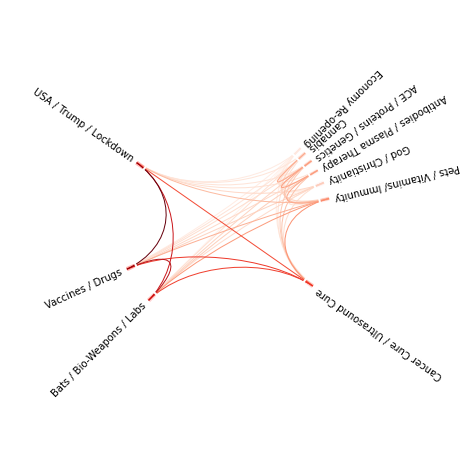

In [32]:
# plot the relations between the clusters
draw_clusters_relations_chord (
  fake_news_labels_clusters,
  fake_news_matching_data,
  fake_news_clusters_annotations,
  group_1_angle_space = (145, 225),
  group_2_angle_space = (-35, 45) 
)

In [33]:
# prints news from a corpus given the associated news location indexes

def print_news(
    corpus,
    loc_indexes
) :

  for loc_index in loc_indexes :
    content = corpus.iloc[loc_index]["content"];

    print(textwrap.fill(content, 120, break_long_words=False, replace_whitespace = False));
    print("-" * 120);

In [34]:
# slices the matching data so it will contain
# only the data for a target set of tokens

def get_tokens_matching_data (
    matching_data,
    all_tokens,
    included_tokens
):

  tokens_indexes = [];
  for token in included_tokens :
    token_index = np.where(all_tokens == token);
    tokens_indexes.append(token_index);
 
  tokens_matching_data = np.squeeze(matching_data[:, tokens_indexes]);
  if (tokens_matching_data.ndim == 1) :
    tokens_matching_data = np.transpose(np.array([tokens_matching_data]));

  return tokens_matching_data;

# extracts the most representative news from the corpus based on tokens
# (i.e. the news containing the most tokens from a specific set)
def find_token_representative_news_indexes (
    matching_data,
    all_tokens,
    included_tokens,
    must_be_tokens = None,
    max_limit = None
) :
  
  # news indexes
  news_indexes = range(0, matching_data.shape[0]);

  # get the matching data related to included tokens
  included_tokens_matching_data = get_tokens_matching_data (
    matching_data,
    all_tokens,
    included_tokens
  );

  # counts the number of tokens per matched news
  included_tokens_count = np.sum(included_tokens_matching_data, axis = 1);

  # prepare excluding invalid news 
  excluded_news_indexes = np.array([]);

  # determine if any news are to be excluded bases on the must-be tokens criteria
  if not(must_be_tokens is None) :
    for token in must_be_tokens :
      token_index = np.where(all_tokens == token);
      token_excluded_news_indexes = np.where(matching_data[:, token_index] == 0);
      excluded_news_indexes = np.append(excluded_news_indexes, token_excluded_news_indexes);
      excluded_news_indexes = np.unique(excluded_news_indexes);


  # exclude stories that does not contain at least one token to be included
  excluded_news_indexes = np.append(excluded_news_indexes, np.where(included_tokens_count == 0)[0]);
  excluded_news_indexes = np.unique(excluded_news_indexes);

  # extract the most representative news 
  sorted_indexes = np.flip(np.argsort(included_tokens_count));

  # exclude invalid stories
  sorted_indexes = np.array([i for i in sorted_indexes if i not in excluded_news_indexes]);

  # apply limits
  if not(max_limit is None):
    limit = min(max_limit, sorted_indexes.shape[0]);
    sorted_indexes = sorted_indexes[0:limit];

  return sorted_indexes;

# extracts the most representative news from the corpus based on cluster appartenence
# (i.e. the news containing the most tokens from a specific cluster)
def find_cluster_representative_news_indexes (
  cluster_labels, # the tokens clustered with their labels
  cluster_label, # the cluster label
  matching_data,
  all_tokens,
  must_be_tokens = None,
  max_limit = None
) :
  cluster_tokens = get_cluster_tokens(
      cluster_labels,
      cluster_label,
      all_tokens
  );
  
  representative_news_indexes = find_token_representative_news_indexes (
    matching_data,
    all_tokens,
    cluster_tokens,
    must_be_tokens = must_be_tokens,
    max_limit = max_limit
  );

  return representative_news_indexes;

In [35]:
# identify the largest cluster
cluster_coverages = [
                      get_cluster_coverage (
                        fake_news_labels_clusters,
                        cluster,
                        fake_news_matching_data
                      ) 
                      for cluster in np.unique(fake_news_labels_clusters)
                    ];

index_max_cluster_coverage = np.argmax(cluster_coverages);
max_cluster_coverage_label= np.unique(fake_news_labels_clusters)[index_max_cluster_coverage];

# print top 3 stories from the largest cluster
print_news(
    generic_fake_news,
    find_cluster_representative_news_indexes(
      fake_news_labels_clusters,
      max_cluster_coverage_label,  
      raw_fake_news_matching_data,
      fake_news_tokens,
      max_limit = 3  
    )
  );

THE HIGH COST OF LOCKING DOWN AMERICA: “WE’VE SEEN A YEAR’S WORTH OF SUICIDE ATTEMPTS IN THE LAST FOUR WEEKS” Locking
down much of the country may have helped to “flatten the curve” a bit, but it has also had some very serious
consequences that public health officials did not anticipate. 

Humans were created to be social creatures, and forcing
us to isolate ourselves from one another for weeks on end has turned out to be quite problematic.

This has especially
been true for those that live alone.

Today, the U.S. has a higher percentage of one person households than ever before,
and keeping those individuals totally isolated in their own homes is not that different from putting prison inmates in
solitary confinement for an extended period of time. 

In both cases, it can be just a matter of time before people
mentally break. The High Cost Of Locking Down America: “We’ve Seen A Year’s Worth Of Suicide Attempts In The Last Four
Weeks”
IMAGE CREDITS: GETTY IMAGES / JUSTIN PAGET.

Locking

In [36]:
# explore the USA / Trump / Lockdown cluster
print_news(
    generic_fake_news,
    find_cluster_representative_news_indexes(
      fake_news_labels_clusters,
      2,  
      raw_fake_news_matching_data,
      fake_news_tokens,
      must_be_tokens = ["american", "trump", "lockdown"],
      max_limit = 5   
    )
  );

Coronavirus India Live Updates: India records 1648 new Covid-19 cases, 37 deaths in single day First Covid-19 hotspot in
Delhi declared non-containment zone 19:40 PM IST: Karnataka chief secretary has written to All district collectors
saying that migrant labourers can be moved to different districts using KSRTC buses. Masks will be compulsory, social
distancing will have to be maintained and a bus will have 40% pax, the chief secy said. 19:26 PM IST: Uttar Pradesh's
Gautam Buddh district on Friday reported five fresh cases of coronavirus. With this, the district's coronavirus count
has reached 109. 19:24 PM IST: First Covid-19 hotspot in Delhi, Mansara Apartments in the Vasundhra Enclave area, has
been declared as a non-containment zone after no new case of coronavirus was reported from there. "No new case in
Mansara Apts in Vasundhara Enclave. Therefore, this containment zone is being de-contained. Operation Shield was
successful becoz of cooperation from people living in this zone,"

In [37]:
# explore the Virus/Drugs cluster
print_news(
    generic_fake_news,
    find_cluster_representative_news_indexes(
      fake_news_labels_clusters,
      5,  
      raw_fake_news_matching_data,
      fake_news_tokens,
      must_be_tokens = ['vaccin', 'drug'],
      max_limit = 5   
    )
  );


Coronavirus 2019-nCoV, Part 1: Communist Coverup, or Pandemic Bioweapon of Mass Destruction? Coronavirus 2019-nCoV, able
to enter and infect human cells’ ACE2 receptor via its spike protein. The official story about Coronavirus 2019 nCoV is
that it “appears to have originated in the Huanan Seafood Wholesale Market in Wuhan, a Chinese city about 650 miles
south of Beijing that has a population of more than 11 million people.” This tale has been officially reported as early
as January 9th by CCP’s state-owned and operated news channel, Xinhuanet, New-type coronavirus causes pneumonia in
Wuhan: expert , reported by local Chinese authorities to the US National Library of Medicine database, Outbreak of
Pneumonia of Unknown Etiology in Wuhan China: the Mystery and the Miracle and to the International Journal of Infectious
Diseases database, The continuing 2019-nCoV epidemic threat of novel coronaviruses to global health — The latest 2019
novel coronavirus outbreak in Wuhan, China . Claims of

In [38]:
# explore the Bats/Weapons cluster
print_news(
    generic_fake_news,
    find_cluster_representative_news_indexes(
      fake_news_labels_clusters,
      0,  
      raw_fake_news_matching_data,
      fake_news_tokens,
      must_be_tokens = ['bat', 'weapon'],
      max_limit = 5   
    )
  );

The Corona Virus Hysteria: Was China Being Set Up? I have been watching the continuing hysteria that is being pushed
even today by the criminals in the Jew spew media, and suffice to say they have FAILED in their attempts to have
everyone cower in fear due to this "Coronavirus epidemic" that absolutely is failing to materialize....
What people do
need to understand that in spite of the continuing hype and fear mongering, the number of actual victims of this
"epidemic" is now levelling off and there is evidence that it is actually on the decline.... Oh sure, there will still
be some 'deaths' due to this virus but in comparison to those who will possibly die from the seasonal Influenza
"epidemic" those numbers will continue to be minuscule in comparison...
So what happened? Well, the Chinese
administration did the right thing right off the bat and basically quarantine a large segment of their population
centred around the original outbreak area in Wuhan province and city... And yes, even

In [39]:
# the most complex fake news samples from the corpus
# having the largest set of fake news tokens
print_news(
    generic_fake_news,
    find_token_representative_news_indexes(
      raw_fake_news_matching_data,
      fake_news_tokens,
      fake_news_tokens,
      must_be_tokens = None,
      max_limit = 5   
    )
  );

Coronavirus 2019-nCoV, Part 1: Communist Coverup, or Pandemic Bioweapon of Mass Destruction? Coronavirus 2019-nCoV, able
to enter and infect human cells’ ACE2 receptor via its spike protein. The official story about Coronavirus 2019 nCoV is
that it “appears to have originated in the Huanan Seafood Wholesale Market in Wuhan, a Chinese city about 650 miles
south of Beijing that has a population of more than 11 million people.” This tale has been officially reported as early
as January 9th by CCP’s state-owned and operated news channel, Xinhuanet, New-type coronavirus causes pneumonia in
Wuhan: expert , reported by local Chinese authorities to the US National Library of Medicine database, Outbreak of
Pneumonia of Unknown Etiology in Wuhan China: the Mystery and the Miracle and to the International Journal of Infectious
Diseases database, The continuing 2019-nCoV epidemic threat of novel coronaviruses to global health — The latest 2019
novel coronavirus outbreak in Wuhan, China . Claims of

In [40]:
# searching for conflicting narratives
# using the tokens already identified
print_news(
    generic_fake_news,
    find_token_representative_news_indexes(
      raw_fake_news_matching_data,
      fake_news_tokens,
      fake_news_tokens,
      must_be_tokens = ["america", "weapon", "attack"],
      max_limit = 5   
    )
  );

The Corona Virus Hysteria: Was China Being Set Up? I have been watching the continuing hysteria that is being pushed
even today by the criminals in the Jew spew media, and suffice to say they have FAILED in their attempts to have
everyone cower in fear due to this "Coronavirus epidemic" that absolutely is failing to materialize....
What people do
need to understand that in spite of the continuing hype and fear mongering, the number of actual victims of this
"epidemic" is now levelling off and there is evidence that it is actually on the decline.... Oh sure, there will still
be some 'deaths' due to this virus but in comparison to those who will possibly die from the seasonal Influenza
"epidemic" those numbers will continue to be minuscule in comparison...
So what happened? Well, the Chinese
administration did the right thing right off the bat and basically quarantine a large segment of their population
centred around the original outbreak area in Wuhan province and city... And yes, even